In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy scipy pandas matplotlib numpy_ringbuffer sklearn

In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')

currencies = ['usd', 'btc', 'eth', 'ltc', 'xrp', 'eos']
pairs = [c + '_usd' for c in currencies if c != 'usd']
volume_keys = [c + '_tx_volume' for c in currencies if c != 'usd']

def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    volumes = [{(k.partition('_')[0] + '_usd'):v for k,v in x.items() if k in volume_keys} for x in data]
    return {
        'prices': pd.DataFrame(prices, index = dates),
        'volumes': pd.DataFrame(volumes, index = dates)
    }

def reduce_data(data, resampling):
    '''Averages prices, sums volumes'''
    prices = data['prices'].resample(resampling).first().fillna(method='ffill')
    volumes = data['volumes'].resample(resampling).sum().fillna(method='ffill')
    return { 'prices': prices, 'volumes': volumes }

def tail_data(data, n):
    '''get the last n points of the given data'''
    prices = data['prices'].tail(n)
    volumes = data['volumes'].tail(n)
    return { 'prices': prices, 'volumes': volumes }

def viz_data(data):
    '''Only plots prices for now'''
    plt.plot(data['prices'] / data['prices'].mean() - 1)
    plt.show()

def find_gaps(data, freq):
    idx_ref = pd.date_range(start=data.index[0], end=data.index[-1],freq=freq)
    gaps = idx_ref[~idx_ref.isin(data.index)]
    return gaps

In [4]:
import os

data_dir = 'data'
exchange = 'test'

df_1m = pd.read_hdf(os.path.join(data_dir, exchange, 'all-pairs-1m-all.h5'))
df_1m

FileNotFoundError: File data/test/all-pairs-1m-all.h5 does not exist

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


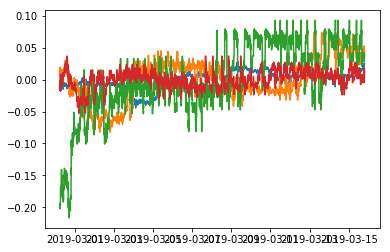

In [5]:
# df_5m = resample(df_1m, '5Min')
# df_5m
data = prep_data('data/data.p')
data_min = reduce_data(prep_data('data/data-minute.p'), '1Min')
data_5min = reduce_data(data_min, '5Min')
data_15min = reduce_data(data_min, '15Min')
viz_data(data_min)

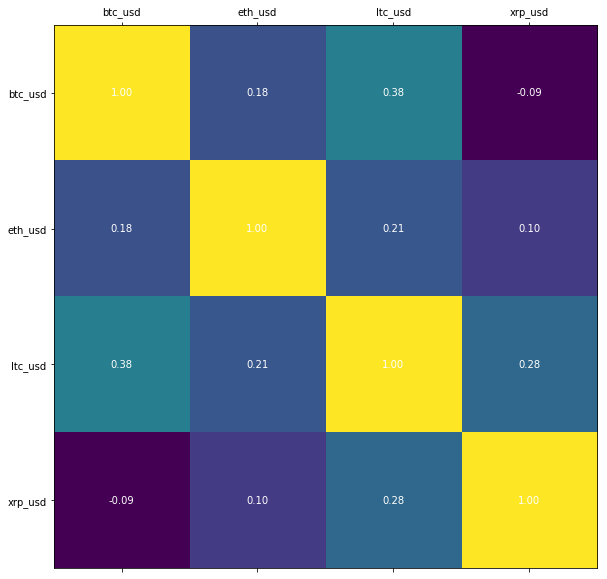

In [6]:
def plot_matrix(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(df)
    plt.xticks(range(len(df.columns)), df.columns);
    plt.yticks(range(len(df.index)), df.index);
    # Loop over data dimensions and create text annotations.
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            ax.text(j, i, '{:0.2f}'.format(df.iloc[i, j]), ha="center", va="center", color="w")

plot_matrix(data_15min['prices'].corr())

In [7]:
def cross_correlate_(x, y):
    return np.argmax(np.correlate(x, y, mode='full')) - len(x) + 1

def cross_correlate(df):
    '''Compute cross-correlation matrix for the given dataframe.'''
    ccs = pd.DataFrame(index=df.columns, columns=df.columns)
    for i in df.columns:
        for j in df.columns:
            if i == j:
                ccs.loc[i,j] = 0
                continue
            if np.isnan(ccs.loc[i,j]):
                ccs.loc[i,j] = cross_correlate_(df[i], df[j])
                ccs.loc[j,i] = -ccs.loc[i,j]
    return ccs

print(cross_correlate(pd.DataFrame([[1,2],[2,1],[1,2],[2,1],[1,2]])))
print(cross_correlate(pd.DataFrame([[1,1],[2,2],[3,3],[4,4],[5,5]])))
    
print(cross_correlate(data_min['prices']))

   0  1
0  0 -1
1  1  0
   0  1
0  0  0
1  0  0
         btc_usd  eth_usd  ltc_usd  xrp_usd
btc_usd        0        0        0        0
eth_usd        0        0        0        0
ltc_usd        0        0        0        0
xrp_usd        0        0        0        0


In [10]:
import numpy as np
import pandas as pd
from trader.util.stats import Gaussian

# Note: Assumes all orders fill at last trade price. Attempting to simulate market-making would
# require combing through book and trade data, which is too much work for us to do at the moment.


def data_currencies(data):
    currencies = ['usd']
    for pair in data['prices'].columns:
        currencies.append(pair.partition('_')[0])
    return currencies

def get_orders(balances, prices, fairs, size, fees):
    '''Given current balances, prices, and fair estimates, determine which orders to place.
    Assumes all pairs are XXX_USD.
    `fairs` should be a Gaussian type. '''
    edges = (fairs / prices) - 1
    
    edges = (prices - fairs.mean) / fairs.stddev  # edges relative to the fair price
    balances = balances.drop(['usd']).rename(lambda c: c + '_usd')
    target_balance_values = edges * -size

    proposed_orders = (target_balance_values / prices - balances)
    edge_better_than_fees = np.abs(fairs.mean / prices - 1) > fees
    # only buy cheap and sell expensive even if it means we overshoot our target balance
    good_direction = edges * proposed_orders < 0

    return proposed_orders * edge_better_than_fees * good_direction


def execute_orders(fees, prices, balances, orders):
    for (pair, size) in orders.items():
        currency = pair.partition("_")[0]
        value = size * prices[pair]
        balances['usd'] -= value
        balances['usd'] -= abs(value) * fees
        balances[currency] += size


def run(strategy, data, size=1000, fees=0):
    balances = pd.Series(dict.fromkeys(data_currencies(data), 0.))
    balances_ = []
    fairs_ = []
    index = data['prices'].index
    for (date, prices) in data['prices'].iterrows():
        volumes = data['volumes'].loc[date]

        fairs = strategy.step(prices, volumes)
        orders = get_orders(balances, prices, fairs, size, fees)
        execute_orders(fees, prices, balances, orders)

        fairs_.append(fairs)
        balances_.append(balances.copy())
    return {
        'data': data,
        'fairs': pd.DataFrame(fairs_, index=index),
        'balances': pd.DataFrame(balances_, index=index)
    }


In [11]:
from strategy import HoldStrategy
from execution import analyze

analyze(run(HoldStrategy(), data))

Gaussian([0. 0. 0. 0.], [[9.18329310e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 7.64096044e+097 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 6.15729424e+098 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.41642265e+104]])
Gaussian([ 0.00000000e+00  0.00000000e+00 -1.11022302e-16  0.00000000e+00], [[9.45531200e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 8.18984050e+097 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 6.92520776e+098 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.46677933e+104]])
Gaussian([0. 0. 0. 0.], [[9.24307344e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 7.84534626e+097 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 6.99868425e+098 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.52754391e+104]])
Gaussian([ 0.00000000e+00  0.00000000e+00 -1.11022302e-16  0.00000

Gaussian([-1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00], [[6.35629552e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.61154771e+097 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 7.03586179e+098 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.37782582e+104]])
Gaussian([ 0.00000000e+00  0.00000000e+00 -1.11022302e-16  0.00000000e+00], [[6.22478882e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.17755275e+097 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 6.81714375e+098 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.36468062e+104]])
Gaussian([ 0.00000000e+00 -1.11022302e-16 -1.11022302e-16  0.00000000e+00], [[6.16878903e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 2.66526722e+097 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 7.07333635e+098 0.00000000e+000]
 [0.00000000e+000 0.00000000e+0

Gaussian([0. 0. 0. 0.], [[8.22031292e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 5.44117925e+096 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 9.57410549e+097 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 9.32916233e+102]])
Gaussian([ 0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00], [[7.62069618e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 5.72331220e+096 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.14632100e+098 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 7.56609347e+102]])
Gaussian([0. 0. 0. 0.], [[7.77439611e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 5.10017145e+096 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.02236840e+098 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 7.80293896e+102]])
Gaussian([0. 0. 0. 0.], [[7.88986907e+093 0.00000000e+000 0.000000

Gaussian([0. 0. 0. 0.], [[4.95214676e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.11013566e+096 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.42722393e+097 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.14560948e+102]])
Gaussian([0. 0. 0. 0.], [[4.73154114e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.04400078e+096 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.25748202e+097 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 9.62508277e+101]])
Gaussian([0. 0. 0. 0.], [[4.49995161e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.13777778e+096 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.08420253e+097 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 4.98598330e+101]])
Gaussian([0. 0. 0. 0.], [[4.21180252e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.2015024

Gaussian([0. 0. 0. 0.], [[1.96593092e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 2.00262859e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.18578725e+097 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.10771152e+101]])
Gaussian([ 0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00], [[2.09038835e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.99085107e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.30800598e+097 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.12316384e+101]])
Gaussian([0. 0. 0. 0.], [[1.90968920e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.66244219e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.26734986e+097 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.11213404e+101]])
Gaussian([0. 0. 0. 0.], [[1.73029532e+093 0.00000000e+000 0.000000

Gaussian([ 0.00000000e+00  0.00000000e+00 -1.11022302e-16  0.00000000e+00], [[1.51690645e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.20220733e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 5.81195850e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.49099988e+101]])
Gaussian([0. 0. 0. 0.], [[1.55093108e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.25578925e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 4.61290018e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.48110089e+101]])
Gaussian([0. 0. 0. 0.], [[1.60951422e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.34077715e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.27356577e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.53636344e+101]])
Gaussian([0. 0. 0. 0.], [[1.68462336e+093 0.00000000e+000 0.000000

Gaussian([0. 0. 0. 0.], [[1.39257285e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 2.38674899e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 5.40330133e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 3.54207181e+101]])
Gaussian([0. 0. 0. 0.], [[1.26913840e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.94048381e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 5.39076322e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 3.17286505e+101]])
Gaussian([0. 0. 0. 0.], [[1.34729111e+093 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 2.06273893e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 5.61798984e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 3.33283613e+101]])
Gaussian([ 0.00000000e+00 -1.11022302e-16  0.00000000e+00 -1.11022302e-16], [[1.30967273e+093 0.00000000e+000 0.000000

Gaussian([0. 0. 0. 0.], [[5.32670573e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 8.25926414e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 2.56903505e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.99252212e+101]])
Gaussian([0. 0. 0. 0.], [[5.23151859e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 7.32557365e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 2.50677732e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.08748592e+101]])
Gaussian([-1.11022302e-16  0.00000000e+00  0.00000000e+00 -1.11022302e-16], [[5.29663990e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 6.98241942e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 2.42924484e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.93114900e+101]])
Gaussian([0. 0. 0. 0.], [[5.20199292e+092 0.00000000e+000 0.000000

Gaussian([-1.11022302e-16 -1.11022302e-16  0.00000000e+00  0.00000000e+00], [[7.59732412e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.17002140e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.74271653e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 3.02002095e+101]])
Gaussian([ 0.00000000e+00  0.00000000e+00 -1.11022302e-16  0.00000000e+00], [[7.58937291e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.21387979e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.75869706e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.91248183e+101]])
Gaussian([0. 0. 0. 0.], [[6.93926177e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.06469218e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.16499355e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.43788209e+101]])
Gaussian([0. 0

Gaussian([ 0.00000000e+00  0.00000000e+00 -1.11022302e-16 -1.11022302e-16], [[3.06913034e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.21303438e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.31059879e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.61462165e+101]])
Gaussian([0. 0. 0. 0.], [[2.78075239e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.12275743e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.19447739e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.33123085e+101]])
Gaussian([0. 0. 0. 0.], [[2.74414192e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.12592427e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.13591603e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.39249622e+101]])
Gaussian([ 0.00000000e+00  0.00000000e+00 -1.11022302e-16  0.00000

Gaussian([ 0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00], [[1.68784798e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 7.70277778e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 2.03036104e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.84766722e+101]])
Gaussian([ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16], [[1.65806622e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 6.87301881e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.93008447e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.75080149e+101]])
Gaussian([-1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00], [[1.54734936e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 5.87695133e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.86934770e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+0

Gaussian([0. 0. 0. 0.], [[2.63638837e+091 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.48633981e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.00998965e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.63310706e+100]])
Gaussian([-1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00], [[2.73931685e+91 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.47767986e+94 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 9.81094817e+94 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.30513551e+99]])
Gaussian([0. 0. 0. 0.], [[2.73590779e+91 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.15425805e+94 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.37918987e+95 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.30513551e+99]])
Gaussian([0. 0. 0. 0.], [[3.17029302e+91 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.0000000

Gaussian([-1.11022302e-16  0.00000000e+00  0.00000000e+00 -1.11022302e-16], [[5.27597158e+91 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.44759361e+93 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.73570745e+95 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00576831e+99]])
Gaussian([-1.11022302e-16  0.00000000e+00 -1.11022302e-16  0.00000000e+00], [[5.22363250e+91 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.15817587e+93 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.64665202e+95 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.10913872e+99]])
Gaussian([ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16], [[7.65286323e+91 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 7.48729259e+93 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 2.24103006e+95 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.00576831e+99]])
Gaussian([

Gaussian([0. 0. 0. 0.], [[1.50868514e+92 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.14438428e+94 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.96655867e+95 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.69467528e+99]])
Gaussian([0. 0. 0. 0.], [[1.25492039e+92 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.12038220e+94 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.89860500e+95 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.69467528e+99]])
Gaussian([ 0.00000000e+00  0.00000000e+00 -1.11022302e-16  0.00000000e+00], [[1.35210736e+92 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.05550898e+94 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.88200364e+95 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 6.94444444e+99]])
Gaussian([0. 0. 0. 0.], [[1.11076287e+92 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.17719686

Gaussian([0. 0. 0. 0.], [[1.18842950e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 2.76228731e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.66464992e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.11419537e+100]])
Gaussian([0. 0. 0. 0.], [[1.17772071e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.28615845e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 4.29766457e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.48418132e+100]])
Gaussian([0. 0. 0. 0.], [[1.45482687e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.34667142e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 4.13667057e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.21359726e+100]])
Gaussian([0. 0. 0. 0.], [[1.44360907e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.2264605

Gaussian([ 0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00], [[2.13524279e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.95431510e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 6.23235896e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.48091910e+100]])
Gaussian([0. 0. 0. 0.], [[2.06708471e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.53233964e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 5.74181991e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.14809928e+100]])
Gaussian([ 0.00000000e+00 -1.11022302e-16  0.00000000e+00  0.00000000e+00], [[1.60186526e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.82754462e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 6.03636399e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.26204061e+100]])
Gaussian([-1.1

 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.80316773e+100]])
Gaussian([ 0.00000000e+00  0.00000000e+00 -1.11022302e-16  0.00000000e+00], [[1.22016566e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.87067745e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 4.59700365e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.83140333e+100]])
Gaussian([0. 0. 0. 0.], [[1.40335299e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.99444965e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 5.12764700e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.06481604e+100]])
Gaussian([ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16], [[1.37905223e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 1.99090539e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 5.13426261e+095 0.00000000e+000]
 [0.00000000e+

Gaussian([ 0.00000000e+00  0.00000000e+00 -1.11022302e-16  0.00000000e+00], [[1.69315389e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 3.52385720e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 8.66460659e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 2.75810511e+100]])
Gaussian([-1.11022302e-16  0.00000000e+00 -1.11022302e-16  0.00000000e+00], [[1.71658020e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 4.03186918e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 9.84189972e+095 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 3.15662052e+100]])
Gaussian([0. 0. 0. 0.], [[1.77799113e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 4.36972364e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.13197465e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 3.48808040e+100]])
Gaussian([0. 0

Gaussian([-1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00], [[2.12632855e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 5.01599475e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.61906924e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 4.94086247e+100]])
Gaussian([-1.11022302e-16  0.00000000e+00  0.00000000e+00  0.00000000e+00], [[2.17856812e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 5.38976206e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.67399203e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 5.24811866e+100]])
Gaussian([0. 0. 0. 0.], [[2.20182106e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 5.29663990e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 1.68794009e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 5.19924141e+100]])
Gaussian([ 0.0

Gaussian([ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16], [[2.00460572e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 7.47412039e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 2.44293284e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 8.34504478e+100]])
Gaussian([0. 0. 0. 0.], [[2.06533833e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 8.95016790e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 2.82560898e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 9.69750205e+100]])
Gaussian([ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16], [[2.19683728e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 9.71576789e+094 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 2.95022812e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.10665051e+101]])
Gaussian([ 0.0

Gaussian([ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.11022302e-16], [[1.84532169e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 2.54099744e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.52398951e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.28779762e+101]])
Gaussian([0. 0. 0. 0.], [[2.19144861e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 2.55462931e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.30698756e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.27335369e+101]])
Gaussian([0. 0. 0. 0.], [[2.34594219e+092 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 2.54612870e+095 0.00000000e+000 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 3.35317058e+096 0.00000000e+000]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.37004679e+101]])
Gaussian([0. 0. 0. 0.], [[2.39613955e+092 0.00000000e+000 0.000000

KeyboardInterrupt: 

In [ ]:
from strategy import KalmanFilterStrategy

analyze(run(KalmanFilterStrategy(correlation_window_size = 64, movement_half_life = 3), data_15min, fees=0.002))

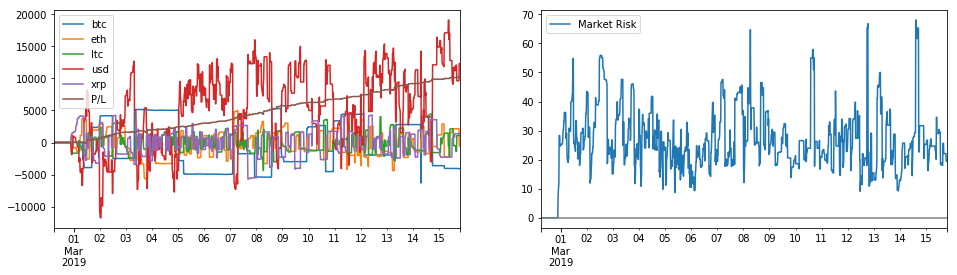

149.63633192906767

Return on maximum market risk: 149.63633192906767
Return on total market risk:   0.2600215423483893
Return on total positions:     0.0008325856791350909
Sharpe ratio:                  3.2416463249515393
Final P/L:                     10181.334797667418
Maximum absolute drawdown:     297.8131204434967
Maximum market risk:           68.04052643096549
Final balances:
usd    12317.580625
btc       -1.039628
eth       -3.720658
ltc       18.493033
xrp     4402.352605
Name: 2019-03-15 19:00:00, dtype: float64


In [15]:
from strategy import Strategy
from trader.util.stats import Ema, Gaussian

import numpy as np
import pandas as pd
from numpy_ringbuffer import RingBuffer


class KalmanFilter(Strategy):
    '''Predicts fairs based on correlated movements between pairs.
    All inputs should be cointegrated.'''

    def __init__(self, correlation_window_size, movement_half_life):
        self.moving_prices_history = None
        self.correlation_window_size = correlation_window_size
        self.moving_prices = Ema(movement_half_life)
        self.moving_volumes = Ema(correlation_window_size)
        self.prev_prediction = None

    def step(self, prices, volumes):
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(
                self.correlation_window_size, dtype=(np.float, len(prices.index)))

        if self.prev_prediction is None:
            self.prev_prediction = self.null_estimate(prices)

        self.moving_prices.step(prices)
        self.moving_volumes.step(volumes)

        if not self.moving_prices.ready:
            return self.null_estimate(prices)

        self.moving_prices_history.append(self.moving_prices.value)

        if len(self.moving_prices_history) < self.correlation_window_size:
            return self.null_estimate(prices)

        df = pd.DataFrame(np.array(self.moving_prices_history), columns=prices.index)
        diffs = df.diff().iloc[1:]
        diff = Gaussian(diffs.iloc[-1], diffs.var())
        # Could also calculate diff from the raw price movements but using smoothed movements
        # for diff seems to improve RoR

        
        stddevs = df.std()
        corr = df.corr()
        deltas = prices - df.mean()
        predicted_delta_means = corr.mul(deltas, axis=0).mul(stddevs, axis=1).div(stddevs, axis=0)
        volume_signals = np.sqrt(self.moving_volumes.value * self.prev_prediction.mean)
        volume_factor = np.max(volume_signals) / volume_signals
        predicted_delta_variances = np.abs(df.cov().mul(stddevs, axis=1).div(stddevs, axis=0)) * volume_factor / (corr * corr)
        predicted_deltas = Gaussian.join([Gaussian(
            predicted_delta_means.loc[i], predicted_delta_variances.loc[i]) for i in prices.index])

        new_prediction = Gaussian.sum([self.prev_prediction, diff]) & (predicted_deltas + df.mean())
        self.prev_prediction = new_prediction
        return new_prediction

analyze(run(KalmanFilter(correlation_window_size = 64, movement_half_life = 1), data_15min, fees=0.002))

In [ ]:
from strategy import CointegratorStrategy

analyze(run(CointegratorStrategy(cointegration_window_size = 64), tail_data(data, 1000)))

In [ ]:
analyze(run(CointegratorStrategy(cointegration_window_size = 16), data_15min))

In [ ]:
analyze(run(KalmanFilterStrategy(
    correlation_window_size = 480,
    movement_half_life = 1
), tail_data(data_min, 10000), fees = 0.002))

In [ ]:
from strategy import CombinedStrategy

analyze(run(CombinedStrategy([
    KalmanFilterStrategy(correlation_window_size = 60, movement_half_life = 3),
    CointegratorStrategy(cointegration_window_size = 16)
]), data_15min))

In [ ]:
analyze(run(CointegratorStrategy(cointegration_window_size = 512), data_5min))

In [ ]:
analyze(run(KalmanFilterStrategy(correlation_window_size = 165, movement_half_life = 70), data_5min))

In [ ]:
analyze(run(CombinedStrategy([
    KalmanFilterStrategy(correlation_window_size = 16, movement_half_life = 8),
    CointegratorStrategy(cointegration_window_size = 64)
]), tail_data(data_min, 1500)))

Trying window_size: 452 and half_life: 7.37019970716923
  RoR: 31.39060004423915
Trying window_size: 594 and half_life: 3.2538479552507185
  RoR: 30.358317753522737
Trying window_size: 449 and half_life: 18.165556259211172
  RoR: 25.27887918172731
Trying window_size: 581 and half_life: 1.402374423326903
  RoR: 39.16131582429284
Trying window_size: 419 and half_life: 0.20585507935413005
  RoR: 23.881452752980703
Trying window_size: 468 and half_life: 4.51119467995318
  RoR: 32.55965289540743
Trying window_size: 685 and half_life: 27.419352928025482
  RoR: 13.875843371107885
Trying window_size: 639 and half_life: 9.025018837178589
  RoR: 22.39113027899303
Trying window_size: 444 and half_life: 0.7388083873556753
  RoR: 37.266145796668546
Trying window_size: 610 and half_life: 13.444000721160961
  RoR: 18.727460919910648
Trying window_size: 444 and half_life: 6.738442733405977
  RoR: 29.480422629388766
Trying window_size: 428 and half_life: 9.566359484274612
  RoR: 26.5222460389048
Trying

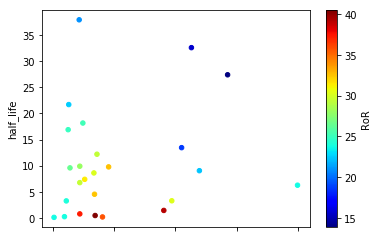

In [13]:
import random

def find_best_window_sizes(data, n):
    points = []
    best = None
    best_ror = 0
    for _ in range(n):
        movement_half_life = random.expovariate(1) * 15
#         window_ratio = random.uniform(1, 10)
#         window_size = max(3, int(movement_half_life * window_ratio))
#         movement_half_life = 2
        window_size = int(random.expovariate(1) * 100) + 400
#         window_size = int(random.expovariate(1) * 30) + 3
#         window_size = 4
#         window_size = 32
        print('Trying window_size: {0} and half_life: {1}'.format(window_size, movement_half_life))
        ror = analyze(run(KalmanFilterStrategy(window_size, movement_half_life), data, fees = 0.002), plot=False)
        print('  RoR: {0}'.format(ror))
        point = { 'window_size': window_size, 'half_life': movement_half_life, 'RoR': ror }
        points.append(point)
        if ror > best_ror:
            best = point
            best_ror = ror
    print('Best found:')
    print(best)
    pd.DataFrame(points).plot.scatter('window_size', 'half_life', c='RoR', colormap='jet')
    
find_best_window_sizes(tail_data(data_min, 1500), 25)